In [122]:
# imports 

from drn_interactions.io import load_derived_generic
from drn_interactions.transforms import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from drn_interactions.transforms.brain_state import StateHandler, RawEEGHandler
from drn_interactions.transforms.brain_state_spikes import (
    align_spikes_to_states_long, align_spikes_to_phase_long, align_bins_to_states_long,
    )
from drn_interactions.responders.brain_state_responders import BSResonders
from drn_interactions.transforms.nbox_transforms import segment_spikes
from drn_interactions.spiketrains.spiketrain_stats import cv_isi_burst
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.responders.brain_state import SpikeRateResonders, PhaseLockResponders
from drn_interactions.spiketrains.neurontype_props import ChiSquarePostHoc

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd

from drn_interactions.plots.circular import circular_hist

from IPython.display import display

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
sns.set_theme(context="paper", style="ticks")

In [124]:
# preprocessing

In [125]:
# load_data
session_names = ExperimentInfo.eeg_sessions


eeg_states = (
    load_derived_generic("eeg_states.csv")
    # .rename(columns={"cluster": "state"})
    .query("quality == 'good'")
)
sessions = [s for s in session_names if s in eeg_states.session_name.unique()]

neuron_types = load_derived_generic("neuron_types.csv")


In [126]:
states_handler = StateHandler(
    quality_to_include=("good",),
    t_start=0,
    t_stop=1800,
    session_names=session_names,
)
spikes_handler = SpikesHandler(
    block="pre",
    t_start=0,
    bin_width=1,
    t_stop=1800,
    session_names=session_names,
    
)

df_aligned = align_bins_to_states_long(
    spikes_handler=spikes_handler,
    states_handler=states_handler,
    neuron_types=neuron_types
)
df_aligned["zcounts"] = (
    df_aligned
    .groupby("neuron_id")["counts"]
    .transform(zscore)
)

In [127]:
mod = SpikeRateResonders(df_value_col="zcounts", round_output=2)
anova, contrasts = mod.get_anova(df_aligned, fit_neuron_types=True)

display(anova)
# display(contrasts)

responders = mod.get_responders(df_aligned, abs_diff_thresh=0.1)
display(responders.sample(3))



/opt/miniconda3/envs/drn/lib/python3.8/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,neuron_type,0.00,2,139,0.00,0.03,0.97,0.00,NaN
1,state,10.64,1,139,10.64,33.89,0.00,0.20,1.0
2,Interaction,0.40,2,139,0.20,0.64,0.53,0.01,NaN


,neuron_id,n_sw,n_act,Mean_sw,Mean_act,Diff,U,p,sig
40,126,1491.0,308.0,0.19,-0.93,-1.12,432694.0,0.00,True
74,180,1074.0,725.0,0.13,-0.20,-0.33,417997.0,0.00,True
124,2564,819.0,980.0,-0.04,0.03,0.07,399423.5,0.18,False


/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


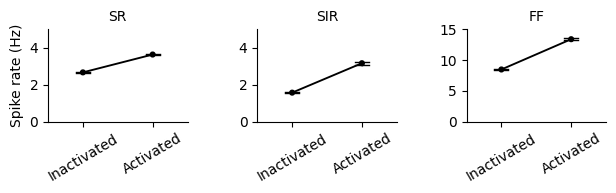

In [46]:
from drn_interactions.plots.pallets_cmaps import PAL_GREY_BLACK

g = sns.FacetGrid(
    data=df_aligned,
    col="neuron_type",
    col_order=["SR", "SIR", "FF"],
    gridspec_kws=dict(wspace=0.5),
    sharey=False,
    height=1.2,
    aspect=2.0,
    
)

g.map_dataframe(
    sns.pointplot, x="state", 
    y="counts", 
    ci=95, 
    capsize=0.2, 
    errwidth=1, 
    color="black",
    scale=0.5
)

g.set_titles("{col_name}")
g.set_ylabels("Spike rate (Hz)")
g.set_xlabels("")
g.axes[0, 0].set_ylim(0, 5)
g.axes[0, 1].set_ylim(0, 5)
g.axes[0, 2].set_ylim(0, 15)
g.set_xticklabels(["Inactivated", "Activated"], rotation=30.5)

g.savefig(Config.fig_dir / "bs spike rate group responders.png", 
          dpi=300, bbox_inches="tight", transparent=True, )


/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


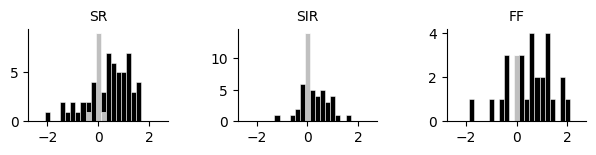

In [70]:
df_su = responders.merge(neuron_types[["neuron_type", "neuron_id"]])


g = sns.FacetGrid(
    data=df_su,
    col="neuron_type",
    col_order=["SR", "SIR", "FF"],
    gridspec_kws=dict(wspace=0.5),
    sharey=False,
    height=1.2,
    aspect=2.0,
)

g.map_dataframe(
    sns.histplot, 
    x="Diff", 
    hue="sig",
    bins=np.arange(-2.5, 2.6, 0.2),
    color="black",
    palette=PAL_GREY_BLACK,
    alpha=1,
    multiple="stack",
    edgecolor="white",
    hue_order=[True, False],
)

g.set_titles("{col_name}")
g.set_xlabels("")
g.set_ylabels("")

g.savefig(Config.fig_dir / "bs spike rate su responders hist.png",
            dpi=300, bbox_inches="tight", transparent=True, )


In [86]:
### Consistency

def load_data(t_start, t_stop, states_path=None):
    states_handler = StateHandler(
        quality_to_include=("good",),
        t_start=t_start,
        t_stop=t_stop,
        # session_names=session_names,
        states_path=None
    )
    spikes_handler = SpikesHandler(
        block="pre",
        t_start=t_start,
        bin_width=1,
        t_stop=t_stop,
    )
    neuron_types = load_derived_generic("neuron_types.csv")
    df_aligned = align_bins_to_states_long(
        spikes_handler=spikes_handler,
        states_handler=states_handler,
        neuron_types=neuron_types
    )
    df_aligned["zcounts"] = (
        df_aligned
        .groupby("neuron_id")["counts"]
        .transform(zscore)
    )
    return df_aligned


def get_response(df):
    df["response"] = np.select(
        condlist=[(df["sig"]) & (df["Diff"] > 0), (df["sig"]) & (df["Diff"] < 0), np.isnan(df["Diff"])],
        choicelist=["Activated-Preferring", "Inactivated-Preferring", "missing"],
        default="Non-Responder",
    )
    return df



df_aligned_first_half = load_data(0, 900)
df_aligned_second_half = load_data(900, 1800)

mod_first_half = SpikeRateResonders(df_value_col="zcounts", round_output=2)
mod_second_half = SpikeRateResonders(df_value_col="zcounts", round_output=2)

# anova, contrasts = mod_first_half.get_anova(df_aligned_first_half, fit_neuron_types=True)

responders_first_half = mod_first_half.get_responders(df_aligned_first_half, abs_diff_thresh=0.1).pipe(get_response)
responders_second_half = mod_second_half.get_responders(df_aligned_second_half, abs_diff_thresh=0.1).pipe(get_response)


# display(responders.sample(3))


In [141]:
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr



def get_overlap(df1, df2, neuron_type=None):
    df1 = df1.copy()[["neuron_id", "Diff"]].set_index("neuron_id")
    df2 = df2.copy()[["neuron_id", "Diff"]].set_index("neuron_id")
    df = df1.join(df2, on="neuron_id", lsuffix="_first_half", rsuffix="_second_half")
    df = df.dropna()
    df = df[(df["Diff_first_half"] != "missing") & (df["Diff_second_half"] != "missing")]
    if neuron_type is not None:
        df = df.join(neuron_types[["neuron_id", "neuron_type"]]).query("neuron_type == @neuron_type").set_index("neuron_id")
    return spearmanr(df["Diff_first_half"].values, df["Diff_second_half"].values)

In [142]:
get_overlap(responders_first_half, responders_second_half)

SpearmanrResult(correlation=0.5122357670610898, pvalue=3.612990016037421e-06)

In [88]:

df1 = responders_first_half.copy()[["neuron_id", "Diff"]].set_index("neuron_id")
df2 = responders_second_half.copy()[["neuron_id", "Diff"]].set_index("neuron_id")
df = df1.join(df2, on="neuron_id", lsuffix="_first_half", rsuffix="_second_half")
df = df.dropna()
df = df[(df["Diff_first_half"] != "missing") & (df["Diff_second_half"] != "missing")]


In [89]:
spearmanr(df["Diff_first_half"].values, df["Diff_second_half"].values)

SpearmanrResult(correlation=0.5122357670610898, pvalue=3.612990016037421e-06)

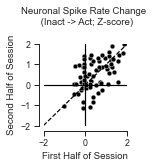

In [159]:
f = plt.figure(figsize=(1.5, 1.5))
ax = f.subplots()

sns.scatterplot(
    data=df.join(neuron_types.set_index("neuron_id")),
    x="Diff_first_half",
    y="Diff_second_half",
    ax=ax,
    color="black",
    # hue="neuron_type"

)

ax.axline((0,0), slope=1, color="black", linestyle="--")
ax.axhline(0, color="black", linestyle="-")
ax.axvline(0, color="black", linestyle="-")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_ylabel("Second Half of Session")
ax.set_xlabel("First Half of Session")
ax.set_title("Neuronal Spike Rate Change \n (Inact -> Act; Z-score)", pad=20)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.95), bbox_transform=ax.transAxes)

sns.despine(ax=ax, offset=5)

f.savefig(Config.fig_dir / "bs spike rate su responders consistency.png",
            dpi=300, bbox_inches="tight", transparent=True, )

In [119]:
### Response similarity with LFP


df_aligned_lfp = load_data(0, 1800, states_path=Config.derived_data_dir / "lfp_states.csv")
# df_aligned_second_half = load_data(900, 1800)

mod_lfp = SpikeRateResonders(df_value_col="zcounts", round_output=2)
responders_lfp = mod_second_half.get_responders(df_aligned_lfp, abs_diff_thresh=0.1).pipe(get_response)


In [128]:
response = get_overlap(responders_lfp, responders.pipe(get_response))

In [129]:
response

SpearmanrResult(correlation=0.5122357670610898, pvalue=3.612990016037421e-06)